## Сделал:

Разметил данные (параметры - n, thresh - длина прогноза и порог чувствительности)

Запустил RF на данных, результат акураси - 0.3, то есть случайное блуждание

выбирать thresh в процентах, а не абсолютных значениях

запустить RF на окне определенной длины (длина - гиперпараметр)

автоматически подбирать window_len

автоматически подбирать thresh, чтобы классы были сбалансированны или как-то еще

кросс-валидация при оценке качества

провести симуляцию торгов:
1. со знанием исторических данных
2. с использованием алгоритмов мл (логрег, рф)

логрег

## Сделать:


сравнить rf с другими моделями классификации

подбирать другие параметры rf

провести симуляцию с использованием наивного алгоритма (какого?)


## Разбиение на классы

Предпосылки

1. Датасет нужно разделить на классы "продавать","покупать","держать"
2. Предлагается ввести "порог", через который должна переступить разница в цене в процентах за определенный период, чтобы можно было принять решение о покупке/продаже
3. Классы должны быть сбалансированы, чтобы было проще решать и оценивать решение задачи классификации

Вариант решения

https://stats.stackexchange.com/questions/387835/measuring-class-imbalance-of-a-dataset - про сбалансированность датасета

1. Введем функцию, которая в зависимости от порога дает разбитый на классы датасет

2. Посчитаем сбалансированность датасета как 
$$J(t) = \sum_i{|IdealSection - PartOfClass_i(t)|}$$
по сути, это оценка насколько датасет отличается от идеально сбалансированного (функционал оценки качества разбиения)
3. Оптимизируем $J$ по $t$

Проблема - J негладкая функция, оптимизировать сложно 
Будем оптимизировать одномерным методом с ограничениями от 0 до 100 (т.к. проценты)

In [1]:
%load_ext autoreload
%autoreload 2

In [51]:
import sys

sys.path.append('../')

In [53]:
import numpy as np
import pandas as pd
import os

from scipy.optimize import minimize_scalar
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import plotly.express as px
import warnings

from src.trade import Simulation
from src.trade.prepare_data import prepare_data, prepare_data_without_window, generate_window, add_results_to_df, get_simulation_results, get_imbalance_by_thresh
from src.trade.model import choose_best_window_size, get_df_of_accuracies_by_window_len_range

In [54]:
warnings.simplefilter("ignore")

In [55]:
from src.trade.prepare_data import read_data, make_labels
import plotly.graph_objects as go
input = '../data/processed/all.csv'
n = 3
thresh = 5
instrument = 'BTC-USD'

Threshold for BTC-USD is 1.86%


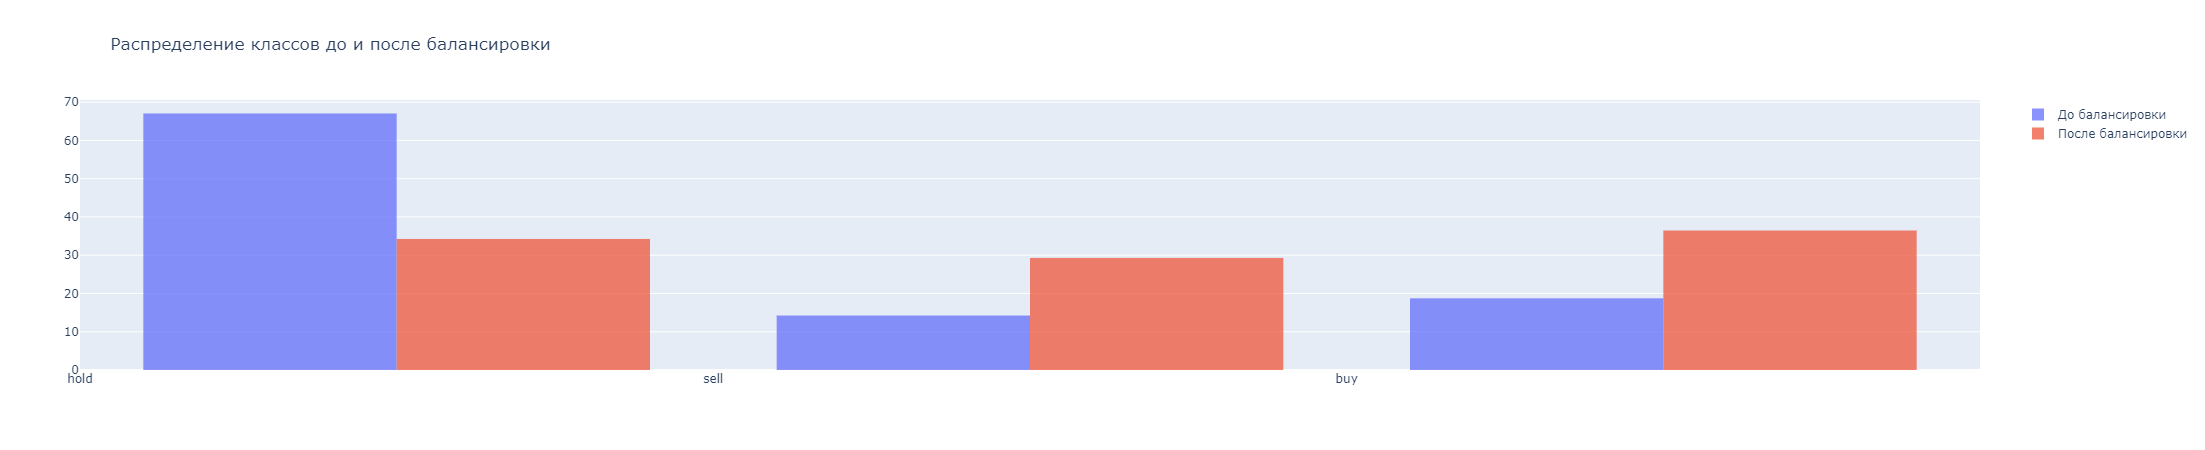

In [11]:
df1 = read_data(input)
df1 = make_labels(df1, f'{instrument} Close', n=n, thresh=thresh).dropna()
df2 = prepare_data(instrument=instrument, n=n, window_len=window_len, bounds=[0.1, 20])


fig = go.Figure()
fig.add_trace(go.Histogram(
    x=df1.label,
    histnorm='percent',
    name='До балансировки', # name used in legend and hover labels
    xbins=dict( # bins used for histogram
        start=-4.0,
        end=3.0,
        size=0.5
    ),
    opacity=0.75
))
fig.add_trace(go.Histogram(
    x=df2.label,
    histnorm='percent',
    name='После балансировки',
    xbins=dict(
        start=-3.0,
        end=4,
        size=0.5
    ),
    opacity=0.75
))

fig.update_layout(
    title_text='Распределение классов до и после балансировки', # title of plot
)

In [16]:
df = read_data(input)

x = np.linspace(0.1, 70, 300)
y = [get_imbalance_by_thresh(i, df) for i in x]

In [18]:
df

,CL=F Open,CL=F Close,CL=F High,CL=F Low,CL=F Volume,EURUSD=X Open,EURUSD=X Close,EURUSD=X High,EURUSD=X Low,EURUSD=X Volume,...,GC=F Close,GC=F High,GC=F Low,GC=F Volume,TSLA Open,TSLA Close,TSLA High,TSLA Low,TSLA Volume,target
Date,,,,,,,,,,,,,,,,,,,,,
2018-01-22,63.610001,63.490002,64.139999,63.169998,625662.0,1.225595,1.225550,1.226663,1.221464,0.0,...,1330.900024,1330.900024,1328.400024,162.0,69.879997,70.311996,71.566002,69.839996,31052000.0,63.490002
2018-01-23,63.880001,64.470001,64.879997,63.700001,662456.0,1.225731,1.225625,1.230700,1.222359,0.0,...,1335.699951,1335.900024,1335.699951,47.0,72.000000,70.557999,72.099998,70.199997,27327000.0,64.470001
2018-01-24,64.419998,65.610001,66.050003,64.339996,887018.0,1.230966,1.231027,1.240199,1.229513,0.0,...,1355.900024,1357.199951,1355.900024,18.0,70.916000,69.178001,70.949997,68.704002,26437500.0,65.610001
2018-01-25,65.879997,65.510002,66.660004,65.080002,771758.0,1.239603,1.239111,1.252992,1.238651,0.0,...,1362.400024,1362.400024,1346.699951,4.0,69.653999,67.528000,69.839996,67.279999,33701500.0,65.510002
2018-01-26,65.250000,66.139999,66.349998,64.910004,678186.0,1.239234,1.239234,1.249016,1.238743,0.0,...,1351.599976,1352.000000,1350.900024,280546.0,68.300003,68.570000,68.800003,67.141998,22697000.0,66.139999
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-01-16,53.799999,52.360001,53.830002,51.830002,165668.0,1.215300,1.215126,1.216249,1.208474,0.0,...,1829.300049,1829.400024,1825.000000,31.0,852.000000,826.159973,859.900024,819.099976,38777600.0,52.360001
2021-01-17,53.799999,52.360001,53.830002,51.830002,165668.0,1.215300,1.215126,1.216249,1.208474,0.0,...,1829.300049,1829.400024,1825.000000,31.0,852.000000,826.159973,859.900024,819.099976,38777600.0,52.360001
2021-01-18,53.799999,52.360001,53.830002,51.830002,165668.0,1.206724,1.206811,1.208620,1.205545,0.0,...,1829.300049,1829.400024,1825.000000,31.0,852.000000,826.159973,859.900024,819.099976,38777600.0,52.360001


In [31]:
def delta(n):
    return int(n // 2) + 1

In [47]:
df = prepare_data_without_window('../data/processed/all.csv', instrument='BTC-USD')

Threshold for BTC-USD is 1.86%


In [ ]:
get_df_of_accuracies_by_window_len_range(df, n, model_type='logistic', delta=20, verbose=True)

Start window_len 1
Accuracy: 31.9044793% for window_len 1

Start window_len 2
Accuracy: 30.1525368% for window_len 2

Start window_len 3
Accuracy: 30.0556479% for window_len 3

Start window_len 4


In [48]:
choose_best_window_size(df, n, 'logistic', delta=20, verbose=True)

Start window_len 1
Accuracy: 27.4912046% for window_len 1

Start window_len 2
Accuracy: 27.9547670% for window_len 2

Start window_len 3
Accuracy: 28.3798225% for window_len 3

Start window_len 4
Accuracy: 31.9958106% for window_len 4

Start window_len 5
Accuracy: 34.5609571% for window_len 5

Start window_len 6
Accuracy: 39.9071502% for window_len 6

Start window_len 7
Accuracy: 43.0440546% for window_len 7

Start window_len 8
Accuracy: 43.3030372% for window_len 8

Start window_len 9
Accuracy: 45.8933411% for window_len 9

Start window_len 10
Accuracy: 44.6892183% for window_len 10

Start window_len 11
Accuracy: 46.6423407% for window_len 11

Start window_len 12
Accuracy: 45.1137878% for window_len 12

Start window_len 13
Accuracy: 46.0777768% for window_len 13

Start window_len 14
Accuracy: 49.2353135% for window_len 14

Start window_len 15
Accuracy: 49.6582287% for window_len 15

Start window_len 16
Accuracy: 53.2498178% for window_len 16

Start window_len 17
Accuracy: 51.5950907% 

(0.5324981775946162, 16.0)

In [15]:
n = 5
delta = int(n // 2)
model_type = 'logistic'

accs = []
wls = []

df = prepare_data_without_window(n=n)
for window_len in range(n - delta, n + delta):
    print('Start window_len', window_len)
    df_window = generate_window(df, window_len=window_len)
    acc = best_window_len_cv(df_window, window_len, model_type=model_type)
    
    accs.append(acc)
    wls.append(window_len)
    print(f'Accuracy: {acc * 100:.1f}% for window_len {window_len}\n')
    

ac = pd.DataFrame({'accuracy': accs, 'window': wls})
acc, window = ac.loc[ac['accuracy'].argmax()]
print(acc, window)

Threshold for CL=F is 1.56%
Start window_len 3
Accuracy: 51.4 for window_len 3

Start window_len 4
Accuracy: 54.8 for window_len 4

Start window_len 5
Accuracy: 57.1 for window_len 5

Start window_len 6
Accuracy: 58.4 for window_len 6

0.583557107691674 6.0


In [30]:
import json

In [34]:
c = json.dumps(ac.to_dict())

In [38]:
with open('abc', 'w') as file:
    file.write(c)

In [10]:
def profit(revenue, cost):
    return (revenue - cost) / cost * 100

In [11]:
window_len = 10
n = 3
start_cap = 15000

for model in ['logistic', 'random_forest', 'ridge']:
    print(model)
    df = prepare_data_without_window(instrument=instrument, n=n, bounds=[0.1, 20])
    df_window = generate_window(df, window_len=window_len)

    df_window = add_results_to_df(df_window, window_len, model_type=model)
    res, best_res = get_simulation_results(df_window, cap=start_cap)

    print(f'Profit: {profit(res, start_cap):.2f}%')
    print(f'Best possible profit: {profit(best_res, start_cap):.2f}%')
    print('res', res, '; best res', best_res)

logistic
1.8574554253958877
Accuracy: 0.3364485981308411
Profit: 22.49%
Best possible profit: 217.07%
res 18372.751953125 ; best res 47560.353515625
random_forest
1.8574554253958877
Accuracy: 0.1588785046728972
Profit: 0.00%
Best possible profit: 217.07%
res 15000 ; best res 47560.353515625
ridge
1.8574554253958877
Accuracy: 0.14018691588785046
Profit: 3.34%
Best possible profit: 217.07%
res 15501.3583984375 ; best res 47560.353515625


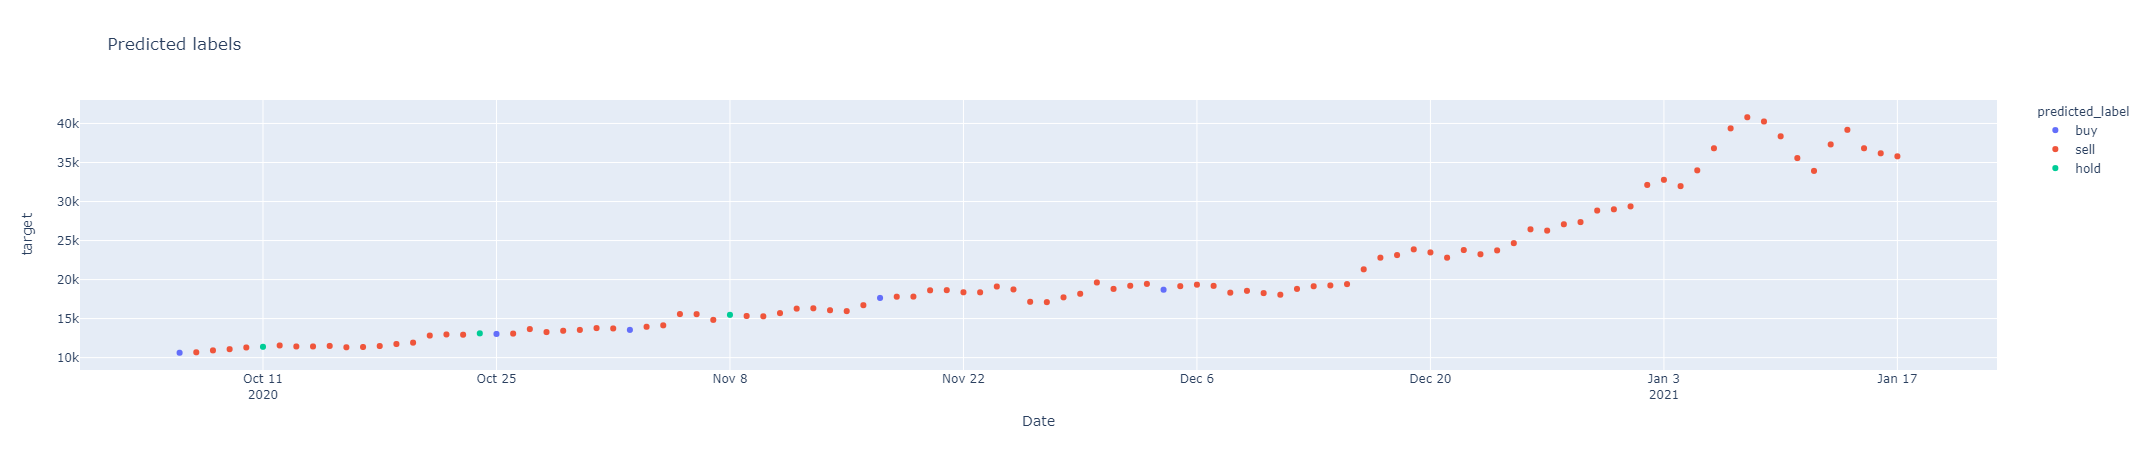

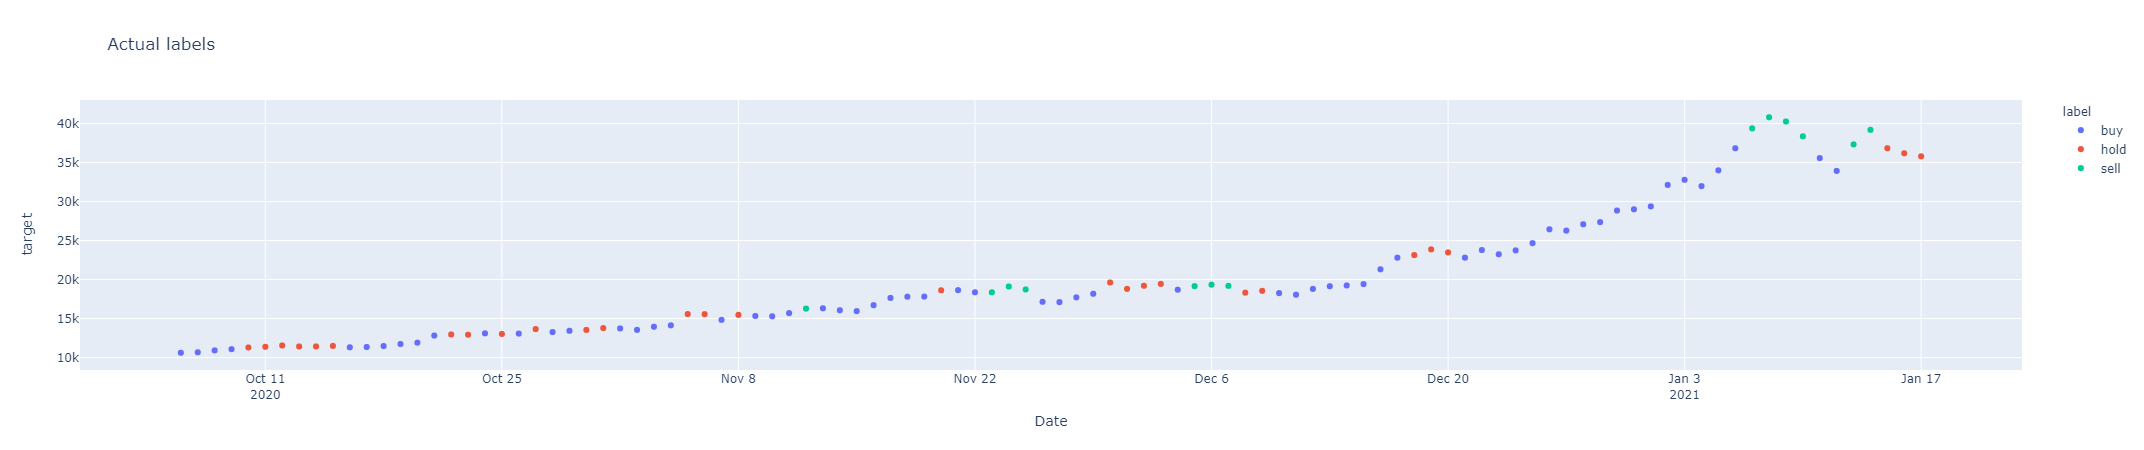

In [12]:
fig = px.scatter(df_window, x=df_window.index, y='target', color='predicted_label', title='Predicted labels')
fig.show()

fig = px.scatter(df_window, x=df_window.index, y='target', color='label', title='Actual labels')
fig.show()